In [7]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import deque, defaultdict

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file('/content/cb_2015_42_tract_500k.shp')

# Print first few rows to understand the stucture
print(gdf.head())

# Check the coordinate reference system (CRS)
gdf = gdf.set_crs('EPSG:4326', allow_override=True)
print(gdf.crs)

                                            geometry
0  POLYGON ((-77.03108 39.80239, -77.02262 39.806...
1  POLYGON ((-79.97927 40.44287, -79.97562 40.444...
2  POLYGON ((-79.91616 40.46699, -79.9146 40.4674...
3  POLYGON ((-79.93304 40.43343, -79.93403 40.437...
4  POLYGON ((-80.03078 40.46212, -80.02462 40.459...
EPSG:4326


In [8]:
# Creating the graph
G = nx.Graph()

# Add nodes (each area is a node)
for idx, row in gdf.iterrows():
    G.add_node(idx, geometry=row["geometry"])

# Add edges based on spatial adjacency
for i, row_i in gdf.iterrows():
    for j, row_j in gdf.iterrows():
        if i != j and row_i["geometry"].touches(row_j["geometry"]):
            G.add_edge(i, j)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 3217 nodes and 9570 edges.


In [9]:
def region_growing(graph, partition_sizes):
    region_labels = {}
    region_id = 0
    for size in partition_sizes:
        for start_node in graph.nodes:
            if start_node not in region_labels:
                region = {start_node}
                frontier = {start_node}
                while frontier and len(region) < size:
                    node = frontier.pop()
                    for neighbor in graph.neighbors(node):
                        if neighbor not in region and neighbor not in region_labels:
                            region.add(neighbor)
                            frontier.add(neighbor)
                for node in region:
                    region_labels[node] = region_id
                region_id += 1
                break
    return region_labels

In [10]:
def region_merging(graph, region_labels):
    unassigned_nodes = {node for node in graph.nodes if node not in region_labels}
    queue = deque(region_labels.keys())
    while unassigned_nodes:
        if not queue:
            node = unassigned_nodes.pop()
            region_labels[node] = max(region_labels.values(), default=-1) + 1
            queue.append(node)
        current_node = queue.popleft()
        for neighbor in graph.neighbors(current_node):
            if neighbor in unassigned_nodes:
                region_labels[neighbor] = region_labels[current_node]
                unassigned_nodes.remove(neighbor)
                queue.append(neighbor)
    return region_labels

In [11]:
def region_splitting(graph, region_labels, partition_sizes):
    region_nodes = defaultdict(set)
    for node, region in region_labels.items():
        region_nodes[region].add(node)
    new_region_labels = region_labels.copy()
    oversized_regions = [r for r, nodes in region_nodes.items() if len(nodes) > max(partition_sizes)]
    next_region_id = max(region_labels.values()) + 1
    for region in oversized_regions:
        nodes = list(region_nodes[region])
        random.shuffle(nodes)
        subregions = []
        visited = set()
        while nodes:
            start_node = nodes.pop()
            if start_node in visited:
                continue
            queue = deque([start_node])
            subregion = set()
            while queue:
                node = queue.popleft()
                if node in visited:
                    continue
                subregion.add(node)
                visited.add(node)
                for neighbor in graph.neighbors(node):
                    if neighbor in nodes and len(subregion) < max(partition_sizes):
                        queue.append(neighbor)
                        nodes.remove(neighbor)
            subregions.append(subregion)
        for subregion in subregions:
            for node in subregion:
                new_region_labels[node] = next_region_id
            next_region_id += 1
    return new_region_labels


In [12]:
def partition_graph(graph, k, partition_sizes):
    region_labels = region_growing(graph, partition_sizes)
    merged_regions = region_merging(graph, region_labels)
    final_regions = region_splitting(graph, merged_regions, partition_sizes)
    return final_regions

In [13]:
def plot_regions(gdf, region_labels, title):
    gdf['region'] = gdf.index.map(region_labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(column="region", cmap="tab10", legend=True, edgecolor="black", ax=ax)
    plt.title(title)
    plt.show()

In [14]:
def main(gdf, k, partition_sizes):
    final_regions = partition_graph(G, k, partition_sizes)
    plot_regions(gdf, final_regions, "Final Partitioned Graph")
    return final_regions

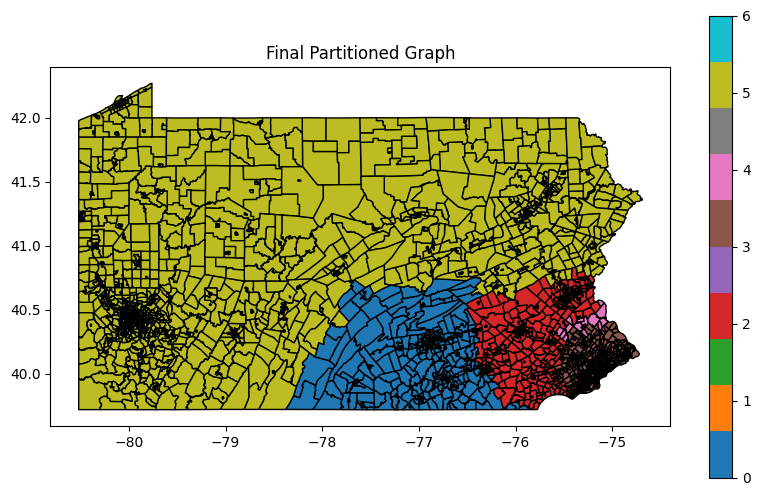

In [19]:
# Run the PRRP-I algorithm on the graph
k = 5
partition_sizes = [250, 1250,250, 500, 1500]
final_regions = main(gdf, k, partition_sizes)